## Setup

In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

100%|██████████| 1.03G/1.03G [00:24<00:00, 44.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


In [25]:
import pandas
import numpy as np
# Dataset to pandas df

In [7]:
import os

# List the contents of the dataset directory
print(os.listdir(path))

['asl_alphabet_test', 'asl_alphabet_train']


In [8]:
import tensorflow as tf
import os

# Define the paths to the training and testing image directories
train_dir = os.path.join(path, 'asl_alphabet_train', 'asl_alphabet_train')
test_dir = os.path.join(path, 'asl_alphabet_test', 'asl_alphabet_test')

# Set image size and batch size
IMG_HEIGHT = 200
IMG_WIDTH = 200
BATCH_SIZE = 32

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=429 # for reproducibility
)

# --- Fix for the test dataset --- #
# The test directory 'asl_alphabet_test/asl_alphabet_test' contains images directly
# (e.g., 'A_test.jpg'), not in subdirectories per class as expected by labels='inferred'.
# We need to manually construct the test dataset.

test_image_paths = []
test_labels = []

# Get the class names from the training dataset for consistent mapping
class_names = train_ds.class_names
class_name_to_label_id = {name: i for i, name in enumerate(class_names)}

for filename in os.listdir(test_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        image_path = os.path.join(test_dir, filename)
        # Extract label from filename (e.g., 'A_test.jpg' -> 'A')
        label_name = filename.split('_')[0]
        if label_name in class_name_to_label_id:
            test_image_paths.append(image_path)
            test_labels.append(class_name_to_label_id[label_name])
        else:
            # Handle cases where a test label might not be in training class names if necessary
            # For this dataset, it's expected to be consistent.
            print(f"Warning: Label '{label_name}' from '{filename}' not found in training class names. Skipping.")

# Convert to TensorFlow tensors
test_image_paths_tensor = tf.constant(test_image_paths)
test_labels_tensor = tf.constant(test_labels, dtype=tf.int32)

# Function to decode and preprocess images
def decode_img(img_path, img_height, img_width):
    img = tf.io.read_file(img_path)
    # Use tf.image.decode_jpeg for .jpg files for more robustness
    img = tf.image.decode_jpeg(img, channels=3) # Decode to 3 channels (RGB)
    img = tf.image.convert_image_dtype(img, tf.float32) # Normalize to [0,1]
    img = tf.image.resize(img, [img_height, img_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

def process_path(file_path, label):
    img = decode_img(file_path, IMG_HEIGHT, IMG_WIDTH)
    return img, label

# Create the test dataset from tensors and apply preprocessing
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths_tensor, test_labels_tensor))
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("\n--- Training Dataset Info ---")
print(f"Number of batches in training dataset: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Class names: {train_ds.class_names}")

print("\n--- Testing Dataset Info ---")
print(f"Number of batches in testing dataset: {tf.data.experimental.cardinality(test_ds).numpy()}")
# For the manually constructed test_ds, class_names are derived from the training set.
print(f"Class names (inferred from training): {class_names}")

Found 87000 files belonging to 29 classes.

--- Training Dataset Info ---
Number of batches in training dataset: 2719
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

--- Testing Dataset Info ---
Number of batches in testing dataset: 1
Class names (inferred from training): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [9]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Manually collect all image paths and their corresponding labels from the training directory
image_paths = []
image_labels = []

# Get class names from the existing train_ds for consistent mapping
class_names = train_ds.class_names
class_name_to_label_id = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        label_id = class_name_to_label_id[class_name]
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                image_paths.append(os.path.join(class_path, filename))
                image_labels.append(label_id)

image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

print(f"Total images found in train_dir: {len(image_paths)}")

# Perform the stratified split on indices
train_indices, val_indices = train_test_split(
    np.arange(len(image_paths)),
    test_size=0.2,
    stratify=image_labels,
    random_state=429
)

# Get the stratified image paths and labels
stratified_train_paths = image_paths[train_indices]
stratified_train_labels = image_labels[train_indices]

stratified_val_paths = image_paths[val_indices]
stratified_val_labels = image_labels[val_indices]

# Create the stratified training dataset
stratified_train_ds = tf.data.Dataset.from_tensor_slices((stratified_train_paths, stratified_train_labels))
stratified_train_ds = stratified_train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
stratified_train_ds = stratified_train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Create the stratified validation dataset
stratified_val_ds = tf.data.Dataset.from_tensor_slices((stratified_val_paths, stratified_val_labels))
stratified_val_ds = stratified_val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
stratified_val_ds = stratified_val_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("\n--- Stratified Dataset Info ---")
print(f"Number of images in stratified training dataset: {len(stratified_train_paths)}")
print(f"Number of images in stratified validation dataset: {len(stratified_val_paths)}")
print(f"Number of batches in stratified training dataset: {tf.data.experimental.cardinality(stratified_train_ds).numpy()}")
print(f"Number of batches in stratified validation dataset: {tf.data.experimental.cardinality(stratified_val_ds).numpy()}")
print(f"Class names: {class_names}")

Total images found in train_dir: 87000

--- Stratified Dataset Info ---
Number of images in stratified training dataset: 69600
Number of images in stratified validation dataset: 17400
Number of batches in stratified training dataset: 2175
Number of batches in stratified validation dataset: 544
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


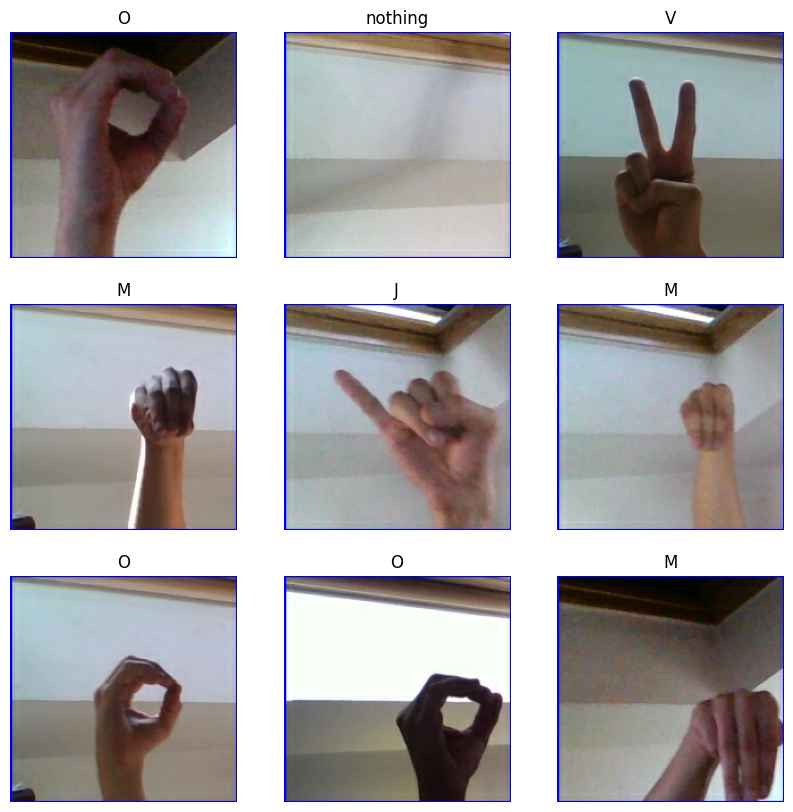

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
plt.show()

## Data Loading, Preprocessing, and Model Utilities

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from PIL import Image

import numpy as np
from sklearn.metrics import f1_score
import copy  # for saving best model weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [12]:
class ASLDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = int(self.labels[idx])

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [13]:
IMG_SIZE = 160
BATCH_SIZE = 64

# ImageNet-like transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

train_dataset = ASLDataset(
    stratified_train_paths,
    stratified_train_labels,
    transform=train_transform
)

val_dataset = ASLDataset(
    stratified_val_paths,
    stratified_val_labels,
    transform=val_transform
)

print(f"Using {len(train_dataset)} training samples")
print(f"Using {len(val_dataset)} validation samples")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


Using 69600 training samples
Using 17400 validation samples
Train batches: 1088
Val batches: 272


## T-A Model

In [11]:
num_classes = len(class_names)

def get_head_only_resnet18(num_classes):
    # Load ImageNet-pretrained ResNet-18
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Freeze all params
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the head (fc layer)
    for param in model.fc.parameters():
        param.requires_grad = True

    return model.to(device)

model = get_head_only_resnet18(num_classes)

# Loss and optimizer
criterion_TA = nn.CrossEntropyLoss()
optimizer_TA = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


In [12]:
# TA Training function
def train_one_epoch_TA(model, dataloader, optimizer, criterion, device, epoch_idx, num_epochs):
    model.train()

    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\n[T-A][Epoch {epoch_idx+1}/{num_epochs}] Training...")

    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        if (batch_idx + 1) % 200 == 0 or (batch_idx + 1) == len(dataloader):
            print(f"  [T-A Train] Processed batch {batch_idx+1}/{len(dataloader)}")

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [13]:
# TA evaluation function
def evaluate_TA(model, dataloader, criterion, device):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    print("  [T-A] Evaluating on validation set...")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

            if (batch_idx + 1) % 200 == 0 or (batch_idx + 1) == len(dataloader):
                print(f"  [T-A Val] Processed batch {batch_idx+1}/{len(dataloader)}")

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    return epoch_loss, epoch_acc, macro_f1

In [14]:
# TA outputs
num_epochs_TA = 3

best_val_f1_TA = 0.0
best_state_dict_TA = None

for epoch in range(num_epochs_TA):
    train_loss_TA, train_acc_TA = train_one_epoch_TA(
        model, train_loader, optimizer_TA, criterion_TA, device, epoch, num_epochs_TA
    )
    val_loss_TA, val_acc_TA, val_f1_TA = evaluate_TA(
        model, val_loader, criterion_TA, device
    )

    if val_f1_TA > best_val_f1_TA:
        best_val_f1_TA = val_f1_TA
        best_state_dict_TA = copy.deepcopy(model.state_dict())

    print(
        f"\n[T-A] Epoch [{epoch+1}/{num_epochs_TA}] "
        f"Train Loss: {train_loss_TA:.4f} | Train Acc: {train_acc_TA:.4f} "
        f"| Val Loss: {val_loss_TA:.4f} | Val Acc: {val_acc_TA:.4f} | Val F1: {val_f1_TA:.4f}"
    )

if best_state_dict_TA is not None:
    model.load_state_dict(best_state_dict_TA)

print(f"\nBest validation macro-F1 for T-A: {best_val_f1_TA:.4f}")



[T-A][Epoch 1/3] Training...
  [T-A Train] Processed batch 200/1088
  [T-A Train] Processed batch 400/1088
  [T-A Train] Processed batch 600/1088
  [T-A Train] Processed batch 800/1088
  [T-A Train] Processed batch 1000/1088
  [T-A Train] Processed batch 1088/1088
  [T-A] Evaluating on validation set...
  [T-A Val] Processed batch 200/272
  [T-A Val] Processed batch 272/272

[T-A] Epoch [1/3] Train Loss: 0.6625 | Train Acc: 0.8681 | Val Loss: 0.2675 | Val Acc: 0.9501 | Val F1: 0.9502

[T-A][Epoch 2/3] Training...
  [T-A Train] Processed batch 200/1088
  [T-A Train] Processed batch 400/1088
  [T-A Train] Processed batch 600/1088
  [T-A Train] Processed batch 800/1088
  [T-A Train] Processed batch 1000/1088
  [T-A Train] Processed batch 1088/1088
  [T-A] Evaluating on validation set...
  [T-A Val] Processed batch 200/272
  [T-A Val] Processed batch 272/272

[T-A] Epoch [2/3] Train Loss: 0.1910 | Train Acc: 0.9651 | Val Loss: 0.1485 | Val Acc: 0.9740 | Val F1: 0.9740

[T-A][Epoch 3/3] Tr

## T-B Model

In [15]:
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 and fc only
for name, param in model.named_parameters():
    if name.startswith("layer4.") or name.startswith("fc."):
        param.requires_grad = True

# Sanity check
trainable_params_TB = [n for n, p in model.named_parameters() if p.requires_grad]
frozen_params_TB = [n for n, p in model.named_parameters() if not p.requires_grad]

print(" T-B: Trainable parameter groups ")
for n in trainable_params_TB:
    print("  ", n)

print("\n T-B: Frozen parameter groups (first 10 shown) ")
for n in frozen_params_TB[:10]:
    print("  ", n)
print(f"... ({len(frozen_params_TB)} frozen params total)")

# Loss and optimizer for TB
criterion_TB = nn.CrossEntropyLoss()

optimizer_TB = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad),
    lr=1e-4
)

 T-B: Trainable parameter groups 
   layer4.0.conv1.weight
   layer4.0.bn1.weight
   layer4.0.bn1.bias
   layer4.0.conv2.weight
   layer4.0.bn2.weight
   layer4.0.bn2.bias
   layer4.0.downsample.0.weight
   layer4.0.downsample.1.weight
   layer4.0.downsample.1.bias
   layer4.1.conv1.weight
   layer4.1.bn1.weight
   layer4.1.bn1.bias
   layer4.1.conv2.weight
   layer4.1.bn2.weight
   layer4.1.bn2.bias
   fc.weight
   fc.bias

 T-B: Frozen parameter groups (first 10 shown) 
   conv1.weight
   bn1.weight
   bn1.bias
   layer1.0.conv1.weight
   layer1.0.bn1.weight
   layer1.0.bn1.bias
   layer1.0.conv2.weight
   layer1.0.bn2.weight
   layer1.0.bn2.bias
   layer1.1.conv1.weight
... (45 frozen params total)


In [16]:
# TB Training function
def train_one_epoch_TB(model, dataloader, optimizer, criterion, device, epoch_idx, num_epochs):
    model.train()

    # Keep BN layers in eval IF they are frozen; keep trainable BNs in train mode
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            if not any(p.requires_grad for p in m.parameters()):
                m.eval()  # frozen BN → eval mode

    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\n[T-B][Epoch {epoch_idx+1}/{num_epochs}] Training...")

    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        if (batch_idx + 1) % 200 == 0 or (batch_idx + 1) == len(dataloader):
            print(f"  [T-B Train] Processed batch {batch_idx+1}/{len(dataloader)}")

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [17]:
# TB evaluation function
def evaluate_TB(model, dataloader, criterion, device):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    print("  [T-B] Evaluating on validation set...")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

            if (batch_idx + 1) % 200 == 0 or (batch_idx + 1) == len(dataloader):
                print(f"  [T-B Val] Processed batch {batch_idx+1}/{len(dataloader)}")

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    return epoch_loss, epoch_acc, macro_f1

In [18]:
# TB output
num_epochs_TB = 3

best_val_f1_TB = 0.0
best_state_dict_TB = None

for epoch in range(num_epochs_TB):
    train_loss_TB, train_acc_TB = train_one_epoch_TB(
        model, train_loader, optimizer_TB, criterion_TB, device, epoch, num_epochs_TB
    )
    val_loss_TB, val_acc_TB, val_f1_TB = evaluate_TB(
        model, val_loader, criterion_TB, device
    )

    if val_f1_TB > best_val_f1_TB:
        best_val_f1_TB = val_f1_TB
        best_state_dict_TB = copy.deepcopy(model.state_dict())

    print(
        f"\n[T-B] Epoch [{epoch+1}/{num_epochs_TB}] "
        f"Train Loss: {train_loss_TB:.4f} | Train Acc: {train_acc_TB:.4f} "
        f"| Val Loss: {val_loss_TB:.4f} | Val Acc: {val_acc_TB:.4f} | Val F1: {val_f1_TB:.4f}"
    )

if best_state_dict_TB is not None:
    model.load_state_dict(best_state_dict_TB)

print(f"\nBest validation macro-F1 for T-B: {best_val_f1_TB:.4f}")


[T-B][Epoch 1/3] Training...
  [T-B Train] Processed batch 200/1088
  [T-B Train] Processed batch 400/1088
  [T-B Train] Processed batch 600/1088
  [T-B Train] Processed batch 800/1088
  [T-B Train] Processed batch 1000/1088
  [T-B Train] Processed batch 1088/1088
  [T-B] Evaluating on validation set...
  [T-B Val] Processed batch 200/272
  [T-B Val] Processed batch 272/272

[T-B] Epoch [1/3] Train Loss: 0.0324 | Train Acc: 0.9894 | Val Loss: 0.0048 | Val Acc: 0.9984 | Val F1: 0.9984

[T-B][Epoch 2/3] Training...
  [T-B Train] Processed batch 200/1088
  [T-B Train] Processed batch 400/1088
  [T-B Train] Processed batch 600/1088
  [T-B Train] Processed batch 800/1088
  [T-B Train] Processed batch 1000/1088
  [T-B Train] Processed batch 1088/1088
  [T-B] Evaluating on validation set...
  [T-B Val] Processed batch 200/272
  [T-B Val] Processed batch 272/272

[T-B] Epoch [2/3] Train Loss: 0.0096 | Train Acc: 0.9974 | Val Loss: 0.0101 | Val Acc: 0.9970 | Val F1: 0.9970

[T-B][Epoch 3/3] Tr

## T-C Model

In [31]:
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer3, layer4 and fc only
for name, param in model.named_parameters():
    if (
        name.startswith("layer3.") or
        name.startswith("layer4.") or
        name.startswith("fc.")
    ):
        param.requires_grad = True

trainable_params_TC = [n for n, p in model.named_parameters() if p.requires_grad]
frozen_params_TC = [n for n, p in model.named_parameters() if not p.requires_grad]

print(" T-C: Trainable parameter groups ")
for n in trainable_params_TC:
    print("  ", n)

print("\n T-C: Frozen parameter groups")
for n in frozen_params_TC[:10]:
    print("  ", n)
print(f"... ({len(frozen_params_TC)} frozen params total)")

 T-C: Trainable parameter groups 
   layer3.0.conv1.weight
   layer3.0.bn1.weight
   layer3.0.bn1.bias
   layer3.0.conv2.weight
   layer3.0.bn2.weight
   layer3.0.bn2.bias
   layer3.0.downsample.0.weight
   layer3.0.downsample.1.weight
   layer3.0.downsample.1.bias
   layer3.1.conv1.weight
   layer3.1.bn1.weight
   layer3.1.bn1.bias
   layer3.1.conv2.weight
   layer3.1.bn2.weight
   layer3.1.bn2.bias
   layer4.0.conv1.weight
   layer4.0.bn1.weight
   layer4.0.bn1.bias
   layer4.0.conv2.weight
   layer4.0.bn2.weight
   layer4.0.bn2.bias
   layer4.0.downsample.0.weight
   layer4.0.downsample.1.weight
   layer4.0.downsample.1.bias
   layer4.1.conv1.weight
   layer4.1.bn1.weight
   layer4.1.bn1.bias
   layer4.1.conv2.weight
   layer4.1.bn2.weight
   layer4.1.bn2.bias
   fc.weight
   fc.bias

 T-C: Frozen parameter groups
   conv1.weight
   bn1.weight
   bn1.bias
   layer1.0.conv1.weight
   layer1.0.bn1.weight
   layer1.0.bn1.bias
   layer1.0.conv2.weight
   layer1.0.bn2.weight
   layer1.0.

In [32]:
# Loss and optimizer for TC
criterion_TC = nn.CrossEntropyLoss()

optimizer_TC = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad),
    lr=1e-4
)

In [33]:
# TC training function
def train_one_epoch_TC(model, dataloader, optimizer, criterion, device, epoch_idx, num_epochs):
    model.train()

    # Keep BN layers in eval IF they are frozen; keep trainable BNs in train mode
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            if not any(p.requires_grad for p in m.parameters()):
                m.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\n[T-C][Epoch {epoch_idx+1}/{num_epochs}] Training...")

    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        if (batch_idx + 1) % 200 == 0 or (batch_idx + 1) == len(dataloader):
            print(f"  [T-C Train] Processed batch {batch_idx+1}/{len(dataloader)}")

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [34]:
# TC eval function
def evaluate_TC(model, dataloader, criterion, device):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    print("  [T-C] Evaluating on validation set...")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

            if (batch_idx + 1) % 200 == 0 or (batch_idx + 1) == len(dataloader):
                print(f"  [T-C Val] Processed batch {batch_idx+1}/{len(dataloader)}")

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    return epoch_loss, epoch_acc, macro_f1

In [35]:
# TC output
num_epochs_TC = 3

best_val_f1_TC = 0.0
best_state_dict_TC = None

for epoch in range(num_epochs_TC):
    train_loss_TC, train_acc_TC = train_one_epoch_TC(
        model, train_loader, optimizer_TC, criterion_TC, device, epoch, num_epochs_TC
    )
    val_loss_TC, val_acc_TC, val_f1_TC = evaluate_TC(
        model, val_loader, criterion_TC, device
    )

    if val_f1_TC > best_val_f1_TC:
        best_val_f1_TC = val_f1_TC
        best_state_dict_TC = copy.deepcopy(model.state_dict())

    print(
        f"\n[T-C] Epoch [{epoch+1}/{num_epochs_TC}] "
        f"Train Loss: {train_loss_TC:.4f} | Train Acc: {train_acc_TC:.4f} "
        f"| Val Loss: {val_loss_TC:.4f} | Val Acc: {val_acc_TC:.4f} | Val F1: {val_f1_TC:.4f}"
    )

if best_state_dict_TC is not None:
    model.load_state_dict(best_state_dict_TC)
    torch.save(best_state_dict_TC, "resnet18_TC_best.pth")
    print("Saved T-C model to local runtime.")


print(f"\nBest validation macro-F1 for T-C: {best_val_f1_TC:.4f}")



[T-C][Epoch 1/3] Training...
  [T-C Train] Processed batch 200/1088
  [T-C Train] Processed batch 400/1088
  [T-C Train] Processed batch 600/1088
  [T-C Train] Processed batch 800/1088
  [T-C Train] Processed batch 1000/1088
  [T-C Train] Processed batch 1088/1088
  [T-C] Evaluating on validation set...
  [T-C Val] Processed batch 200/272
  [T-C Val] Processed batch 272/272

[T-C] Epoch [1/3] Train Loss: 0.0121 | Train Acc: 0.9966 | Val Loss: 0.0429 | Val Acc: 0.9935 | Val F1: 0.9935

[T-C][Epoch 2/3] Training...
  [T-C Train] Processed batch 200/1088
  [T-C Train] Processed batch 400/1088
  [T-C Train] Processed batch 600/1088
  [T-C Train] Processed batch 800/1088
  [T-C Train] Processed batch 1000/1088
  [T-C Train] Processed batch 1088/1088
  [T-C] Evaluating on validation set...
  [T-C Val] Processed batch 200/272
  [T-C Val] Processed batch 272/272

[T-C] Epoch [2/3] Train Loss: 0.0065 | Train Acc: 0.9984 | Val Loss: 0.0292 | Val Acc: 0.9921 | Val F1: 0.9921

[T-C][Epoch 3/3] Tr

## Sanity Checks

In [ ]:
train_set_paths = set(stratified_train_paths.tolist())
val_set_paths = set(stratified_val_paths.tolist())

overlap = train_set_paths & val_set_paths
print("Number of overlapping image paths:", len(overlap))


Number of overlapping image paths: 0


In [ ]:
from sklearn.metrics import confusion_matrix

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

cm = confusion_matrix(all_labels, all_preds)
print("Unique misclassifications:", np.where(cm != np.eye(cm.shape[0]))[0].size)


Unique misclassifications: 37


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Append *flattened* numpy arrays
        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())

# Convert to proper 1D arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

print("Shapes:", all_labels.shape, all_preds.shape)

cm = confusion_matrix(all_labels, all_preds)
cm


Shapes: (17400,) (17400,)


array([[600,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0, 600,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0, 600,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0, 600,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0, 600,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0, 600,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
    

In [ ]:
correct = 0
total = 0

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

print("True Accuracy:", correct / total)


True Accuracy: 0.9986781609195402


In [ ]:
errors = cm.copy()
np.fill_diagonal(errors, 0)

print("Total misclassified samples:", errors.sum())


Total misclassified samples: 23


# New Test Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
save_path_B = "/content/drive/Shareddrives/429_Project/resnet18_TB_best.pth"
torch.save(best_state_dict_TB, save_path_B)
print(f"Model saved to: {save_path_B}")

save_path_A = "/content/drive/Shareddrives/429_Project/resnet18_TA_best.pth"
torch.save(best_state_dict_TA, save_path_A)
print(f"Model saved to: {save_path_A}")


Model saved to: /content/drive/Shareddrives/429_Project/resnet18_TB_best.pth
Model saved to: /content/drive/Shareddrives/429_Project/resnet18_TA_best.pth


In [2]:
import os
newtest = "/content/drive/Shareddrives/429_Project/MYHANDS"

In [ ]:
import os
import tensorflow as tf
import numpy as np

# Define constants that were missing
IMG_HEIGHT = 200
IMG_WIDTH = 200
BATCH_SIZE = 32

# Function to decode and preprocess images - Copied from previous cell (8fb0e95e)
def decode_img(img_path, img_height, img_width):
    img = tf.io.read_file(img_path)
    # Use tf.image.decode_jpeg for .jpg files for more robustness
    img = tf.image.decode_jpeg(img, channels=3) # Decode to 3 channels (RGB)
    img = tf.image.convert_image_dtype(img, tf.float32) # Normalize to [0,1]
    img = tf.image.resize(img, [img_height, img_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

def process_path(file_path, label):
    img = decode_img(file_path, IMG_HEIGHT, IMG_WIDTH)
    return img, label

# Re-initialize lists for new test data
new_test_image_paths = []
new_test_labels = []

# Assuming `newtest`, `class_name_to_label_id` are already defined from previous cells
# `newtest` is the path to the directory containing new test images
# `class_name_to_label_id` maps class names to integer labels

for filename in os.listdir(newtest):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        image_path = os.path.join(newtest, filename)
        new_test_image_paths.append(image_path)

        # Extract label from filename (e.g., 'A1.jpg' -> 'A', 'B_test.jpg' -> 'B')
        label_raw = ''
        for char in filename:
            if char.isalpha():
                label_raw += char
            else:
                break
        label_name = label_raw.upper()

        if label_name in class_name_to_label_id:
            new_test_labels.append(class_name_to_label_id[label_name])
        else:
            print(f"Warning: Label '{label_name}' from '{filename}' not found in training class names. Skipping.")

print(f"Found {len(new_test_image_paths)} images for new testing.")

# Convert to TensorFlow tensors
new_test_image_paths_tensor = tf.constant(new_test_image_paths)
new_test_labels_tensor = tf.constant(new_test_labels, dtype=tf.int32)

# Create the new test dataset from tensors and apply preprocessing
new_test_ds = tf.data.Dataset.from_tensor_slices((new_test_image_paths_tensor, new_test_labels_tensor))
new_test_ds = new_test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
new_test_ds = new_test_ds.batch(BATCH_SIZE)
new_test_ds = new_test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Number of batches in new test dataset: {tf.data.experimental.cardinality(new_test_ds).numpy()}")

Found 20 images for new testing.
Number of batches in new test dataset: 1


In [ ]:
# Invert the mapping so you can see label name from id
id_to_class_name = {v: k for k, v in class_name_to_label_id.items()}

for path, label_id in list(zip(new_test_image_paths, new_test_labels))[:10]:
    filename = os.path.basename(path)
    print(filename, " -> label_id:", label_id, " -> label_name:", id_to_class_name[label_id])


L1.jpg  -> label_id: 11  -> label_name: L
W1.jpg  -> label_id: 22  -> label_name: W
V1.jpg  -> label_id: 21  -> label_name: V
X1.jpg  -> label_id: 23  -> label_name: X
Y1.jpg  -> label_id: 24  -> label_name: Y
V2.jpg  -> label_id: 21  -> label_name: V
W2.jpg  -> label_id: 22  -> label_name: W
T1.jpg  -> label_id: 19  -> label_name: T
S1.jpg  -> label_id: 18  -> label_name: S
D1.jpg  -> label_id: 3  -> label_name: D


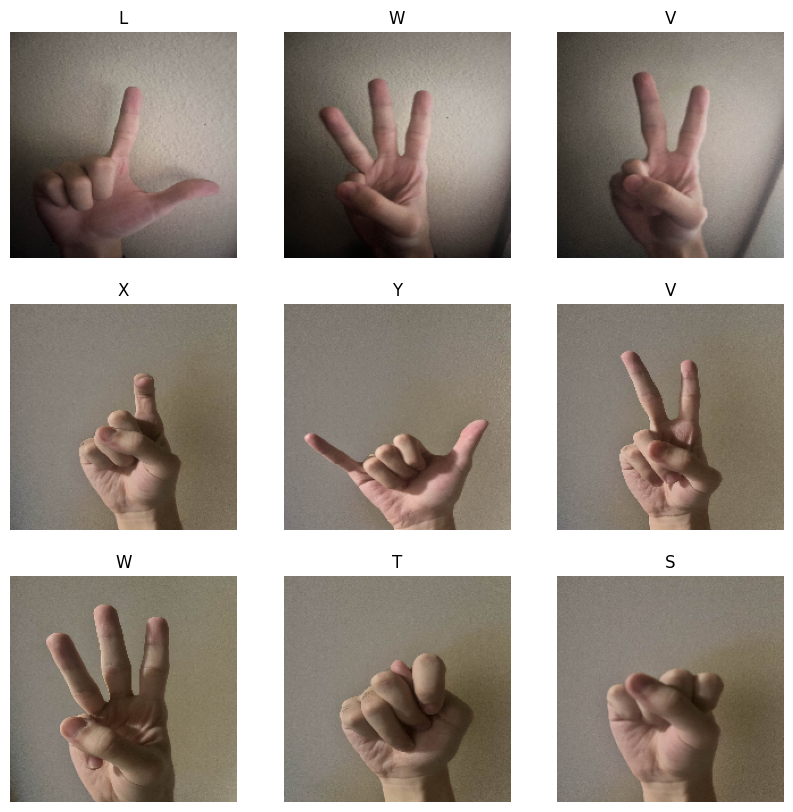

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in new_test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()) # Corrected line: removed .astype("uint8")
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

NUM_CLASSES = 29
model = resnet18(weights=None)
model.fc = nn.Linear(512, NUM_CLASSES)



In [ ]:
state = torch.load(
    "/content/drive/Shared drives/429_Project/resnet18_TC_best.pth",
    map_location="cpu"
)

model.load_state_dict(state)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images_tf, labels_tf in new_test_ds:
        # TF -> NumPy
        images_np = images_tf.numpy()          # (B, H, W, C), values in [0,1]
        labels_np = labels_tf.numpy()          # (B,)

        # NumPy -> Torch, channels first
        images_t = torch.from_numpy(images_np).permute(0, 3, 1, 2)  # (B, 3, H, W)
        images_t = images_t.to(torch.float32).to(device)
        labels_t = torch.from_numpy(labels_np).long().to(device)

        # Forward pass
        logits = model(images_t)               # (B, 29)
        preds = torch.argmax(logits, dim=1)    # (B,)

        # Store for evaluation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_t.cpu().numpy())


In [ ]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).mean()
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.2000


In [ ]:
id_to_class = {v: k for k, v in class_name_to_label_id.items()}

for i in range(10):
    print(f"True: {id_to_class[all_labels[i]]}  |  Pred: {id_to_class[all_preds[i]]}")


True: L  |  Pred: C
True: W  |  Pred: W
True: V  |  Pred: W
True: X  |  Pred: R
True: Y  |  Pred: J
True: V  |  Pred: V
True: W  |  Pred: nothing
True: T  |  Pred: N
True: S  |  Pred: nothing
True: D  |  Pred: C


## Hyperparameter Tuning

In [ ]:
# Load saved state_dict from Shared Drive
state = torch.load(
    "/content/drive/Shareddrives/429_Project/resnet18_TC_best.pth",
    map_location="cuda"   # or "cuda" if you want to load directly to GPU
)

# Load into your model
model.load_state_dict(state)

# Move model to device (GPU if available)
model = model.to(device)

# Set to evaluation mode
model.eval()

print("Loaded T-C best model successfully!")


Loaded T-C best model successfully!


In [ ]:
import copy

# Save a frozen copy of the current (T-C) weights
base_state_dict_TC = copy.deepcopy(model.state_dict())
print("Saved base T-C checkpoint for hyperparameter tuning.")


Saved base T-C checkpoint for hyperparameter tuning.


In [ ]:
import torch.nn as nn

def configure_model_for_TC_tuning(model):
    """
    Freeze conv stem + layer1 + layer2,
    unfreeze layer3 + layer4 + fc for fine-tuning.
    """
    # Freeze everything initially
    for p in model.parameters():
        p.requires_grad = False

    # Unfreeze layer3, layer4 and fc
    for name, p in model.named_parameters():
        if (name.startswith("layer3.") or
            name.startswith("layer4.") or
            name.startswith("fc.")):
            p.requires_grad = True

    trainable = [n for n, p in model.named_parameters() if p.requires_grad]
    print("Trainable params for tuning:")
    for n in trainable:
        print("  ", n)

    return [p for p in model.parameters() if p.requires_grad]


In [ ]:
import numpy as np
from sklearn.metrics import f1_score
import torch

def train_one_epoch_tune(model, dataloader, optimizer, criterion, device):
    model.train()

    # Keep frozen BN layers in eval mode to avoid running-stat drift
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            if not any(p.requires_grad for p in m.parameters()):
                m.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate_tune(model, dataloader, criterion, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    avg_loss = total_loss / total
    avg_acc = correct / total
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    return avg_loss, avg_acc, macro_f1

In [ ]:
import random
import math

def sample_hyperparams():
    log_lr = random.uniform(-5, -3)
    lr = 10 ** log_lr

    optimizer_type = random.choice(["adamw", "sgd"])

    weight_decay = random.choice([0.0, 1e-5, 1e-4, 1e-3])

    # small number of epochs per trial
    num_epochs = random.choice([2, 3])

    return {
        "lr": lr,
        "optimizer_type": optimizer_type,
        "weight_decay": weight_decay,
        "num_epochs": num_epochs,
    }

# quick test
for _ in range(3):
    print(sample_hyperparams())

{'lr': 0.00018590728392578305, 'optimizer_type': 'adamw', 'weight_decay': 1e-05, 'num_epochs': 3}
{'lr': 0.0001035557909182584, 'optimizer_type': 'sgd', 'weight_decay': 0.0, 'num_epochs': 2}
{'lr': 3.386966273819604e-05, 'optimizer_type': 'adamw', 'weight_decay': 1e-05, 'num_epochs': 2}


In [ ]:
criterion = nn.CrossEntropyLoss()

num_trials = 5

results = []
best_overall_f1 = 0.0
best_overall_state = None
best_overall_hparams = None

for trial in range(1, num_trials + 1):
    print(f"\n===== Trial {trial}/{num_trials} =====")

    # 1) Reset model to base T-C weights
    model.load_state_dict(base_state_dict_TC)

    # 2) Ensure correct trainable params for T-C tuning
    trainable_params = configure_model_for_TC_tuning(model)
    model.to(device)

    # 3) Sample hyperparameters
    hparams = sample_hyperparams()
    lr = hparams["lr"]
    opt_type = hparams["optimizer_type"]
    wd = hparams["weight_decay"]
    num_epochs = hparams["num_epochs"]

    print("Hyperparams:", hparams)

    # 4) Create optimizer
    if opt_type == "adamw":
        optimizer = torch.optim.AdamW(trainable_params, lr=lr, weight_decay=wd)
    else:  # sgd
        optimizer = torch.optim.SGD(trainable_params, lr=lr, weight_decay=wd, momentum=0.9)

    best_val_f1_trial = 0.0
    best_state_trial = None

    # 5) Train for num_epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch_tune(
            model, train_loader, optimizer, criterion, device
        )
        val_loss, val_acc, val_f1 = evaluate_tune(
            model, val_loader, criterion, device
        )

        print(
            f"  Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}"
        )

        if val_f1 > best_val_f1_trial:
            best_val_f1_trial = val_f1
            best_state_trial = copy.deepcopy(model.state_dict())

    # record trial results
    results.append({
        "trial": trial,
        "hparams": hparams,
        "best_val_f1": best_val_f1_trial
    })

    # update global best
    if best_val_f1_trial > best_overall_f1:
        best_overall_f1 = best_val_f1_trial
        best_overall_state = best_state_trial
        best_overall_hparams = hparams

print("\n===== Hyperparameter search finished =====")
print("Best overall val F1:", best_overall_f1)
print("Best hyperparams:", best_overall_hparams)


===== Trial 1/5 =====
Trainable params for tuning:
   layer3.0.conv1.weight
   layer3.0.bn1.weight
   layer3.0.bn1.bias
   layer3.0.conv2.weight
   layer3.0.bn2.weight
   layer3.0.bn2.bias
   layer3.0.downsample.0.weight
   layer3.0.downsample.1.weight
   layer3.0.downsample.1.bias
   layer3.1.conv1.weight
   layer3.1.bn1.weight
   layer3.1.bn1.bias
   layer3.1.conv2.weight
   layer3.1.bn2.weight
   layer3.1.bn2.bias
   layer4.0.conv1.weight
   layer4.0.bn1.weight
   layer4.0.bn1.bias
   layer4.0.conv2.weight
   layer4.0.bn2.weight
   layer4.0.bn2.bias
   layer4.0.downsample.0.weight
   layer4.0.downsample.1.weight
   layer4.0.downsample.1.bias
   layer4.1.conv1.weight
   layer4.1.bn1.weight
   layer4.1.bn1.bias
   layer4.1.conv2.weight
   layer4.1.bn2.weight
   layer4.1.bn2.bias
   fc.weight
   fc.bias
Hyperparams: {'lr': 2.0969125095809917e-05, 'optimizer_type': 'adamw', 'weight_decay': 0.0001, 'num_epochs': 2}
  Epoch 1/2 | Train Loss: 0.0009, Train Acc: 0.9998 | Val Loss: 0.0001, 

In [ ]:
if best_overall_state is not None:
    model.load_state_dict(best_overall_state)
    model.to(device)
    model.eval()
    print("Loaded best tuned model with val F1:", best_overall_f1)

    torch.save(
        best_overall_state,
        "/content/drive/Shareddrives/429_Project/resnet18_TC_tuned_best.pth"
    )
    print("Saved tuned model to Shared Drive.")


Loaded best tuned model with val F1: 1.0
Saved tuned model to Shared Drive.


## Testing after Hyperparameter Tuning


In [ ]:
import os
newtest = "/content/drive/Shareddrives/429_Project/MYHANDS"

In [ ]:
import os
import tensorflow as tf
import numpy as np

# Define constants that were missing
IMG_HEIGHT = 200
IMG_WIDTH = 200
BATCH_SIZE = 32

# Function to decode and preprocess images - Copied from previous cell (8fb0e95e)
def decode_img(img_path, img_height, img_width):
    img = tf.io.read_file(img_path)
    # Use tf.image.decode_jpeg for .jpg files for more robustness
    img = tf.image.decode_jpeg(img, channels=3) # Decode to 3 channels (RGB)
    img = tf.image.convert_image_dtype(img, tf.float32) # Normalize to [0,1]
    img = tf.image.resize(img, [img_height, img_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

def process_path(file_path, label):
    img = decode_img(file_path, IMG_HEIGHT, IMG_WIDTH)
    return img, label

# Re-initialize lists for new test data
new_test_image_paths = []
new_test_labels = []

# Assuming `newtest`, `class_name_to_label_id` are already defined from previous cells
# `newtest` is the path to the directory containing new test images
# `class_name_to_label_id` maps class names to integer labels

for filename in os.listdir(newtest):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        image_path = os.path.join(newtest, filename)
        new_test_image_paths.append(image_path)

        # Extract label from filename (e.g., 'A1.jpg' -> 'A', 'B_test.jpg' -> 'B')
        label_raw = ''
        for char in filename:
            if char.isalpha():
                label_raw += char
            else:
                break
        label_name = label_raw.upper()

        if label_name in class_name_to_label_id:
            new_test_labels.append(class_name_to_label_id[label_name])
        else:
            print(f"Warning: Label '{label_name}' from '{filename}' not found in training class names. Skipping.")

print(f"Found {len(new_test_image_paths)} images for new testing.")

# Convert to TensorFlow tensors
new_test_image_paths_tensor = tf.constant(new_test_image_paths)
new_test_labels_tensor = tf.constant(new_test_labels, dtype=tf.int32)

# Create the new test dataset from tensors and apply preprocessing
new_test_ds = tf.data.Dataset.from_tensor_slices((new_test_image_paths_tensor, new_test_labels_tensor))
new_test_ds = new_test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
new_test_ds = new_test_ds.batch(BATCH_SIZE)
new_test_ds = new_test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Number of batches in new test dataset: {tf.data.experimental.cardinality(new_test_ds).numpy()}")

Found 20 images for new testing.
Number of batches in new test dataset: 1


In [ ]:
# Invert the mapping so you can see label name from id
id_to_class_name = {v: k for k, v in class_name_to_label_id.items()}

for path, label_id in list(zip(new_test_image_paths, new_test_labels))[:10]:
    filename = os.path.basename(path)
    print(filename, " -> label_id:", label_id, " -> label_name:", id_to_class_name[label_id])

L1.jpg  -> label_id: 11  -> label_name: L
W1.jpg  -> label_id: 22  -> label_name: W
V1.jpg  -> label_id: 21  -> label_name: V
X1.jpg  -> label_id: 23  -> label_name: X
Y1.jpg  -> label_id: 24  -> label_name: Y
V2.jpg  -> label_id: 21  -> label_name: V
W2.jpg  -> label_id: 22  -> label_name: W
T1.jpg  -> label_id: 19  -> label_name: T
S1.jpg  -> label_id: 18  -> label_name: S
D1.jpg  -> label_id: 3  -> label_name: D


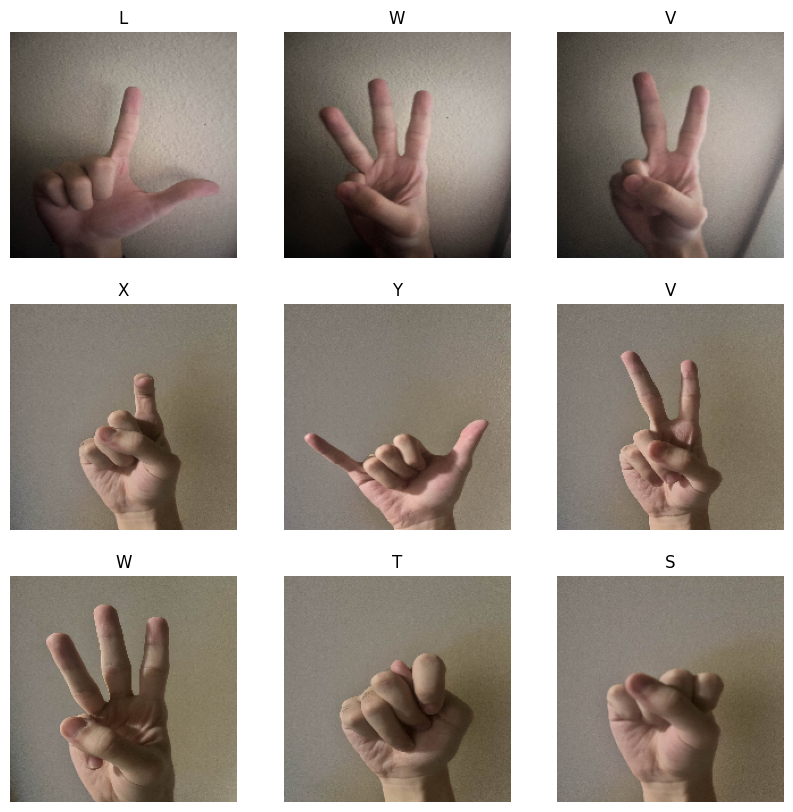

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in new_test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()) # Corrected line: removed .astype("uint8")
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

NUM_CLASSES = 29
model = resnet18(weights=None)
model.fc = nn.Linear(512, NUM_CLASSES)

In [ ]:
state = torch.load(
    "/content/drive/Shared drives/429_Project/resnet18_TC_tuned_best.pth",
    map_location="cpu"
)

model.load_state_dict(state)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images_tf, labels_tf in new_test_ds:
        # TF -> NumPy
        images_np = images_tf.numpy()          # (B, H, W, C), values in [0,1]
        labels_np = labels_tf.numpy()          # (B,)

        # NumPy -> Torch, channels first
        images_t = torch.from_numpy(images_np).permute(0, 3, 1, 2)  # (B, 3, H, W)
        images_t = images_t.to(torch.float32).to(device)
        labels_t = torch.from_numpy(labels_np).long().to(device)

        # Forward pass
        logits = model(images_t)               # (B, 29)
        preds = torch.argmax(logits, dim=1)    # (B,)

        # Store for evaluation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_t.cpu().numpy())

In [ ]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).mean()
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.3000


In [ ]:
id_to_class = {v: k for k, v in class_name_to_label_id.items()}

for i in range(10):
    print(f"True: {id_to_class[all_labels[i]]}  |  Pred: {id_to_class[all_preds[i]]}")


True: L  |  Pred: C
True: W  |  Pred: W
True: V  |  Pred: W
True: X  |  Pred: R
True: Y  |  Pred: Y
True: V  |  Pred: V
True: W  |  Pred: W
True: T  |  Pred: N
True: S  |  Pred: nothing
True: D  |  Pred: H


## Loss vs. Epochs Plotting

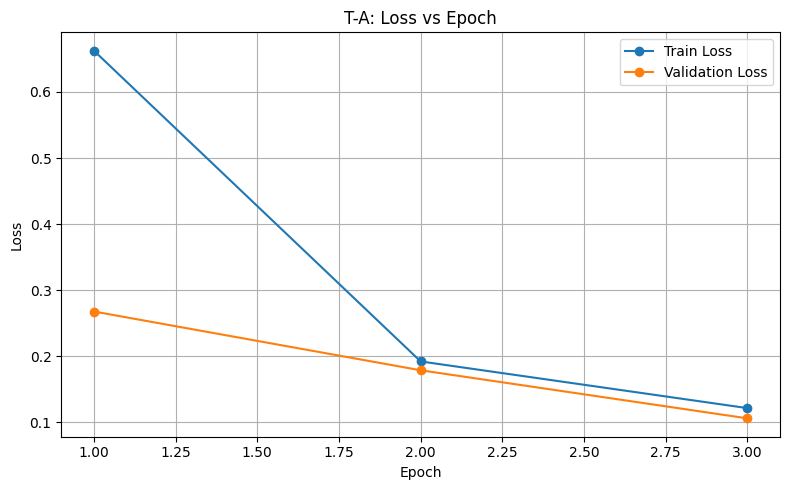

In [22]:
import matplotlib.pyplot as plt

epochs_TA = [1, 2, 3]

train_loss_TA = [
    0.6625,
    0.1919,
    0.1212
]

val_loss_TA = [
    0.2675,
    0.1785,
    0.1057
]

plt.figure(figsize=(8, 5))
plt.plot(epochs_TA, train_loss_TA, marker="o", label="Train Loss")
plt.plot(epochs_TA, val_loss_TA, marker="o", label="Validation Loss")

plt.title("T-A: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

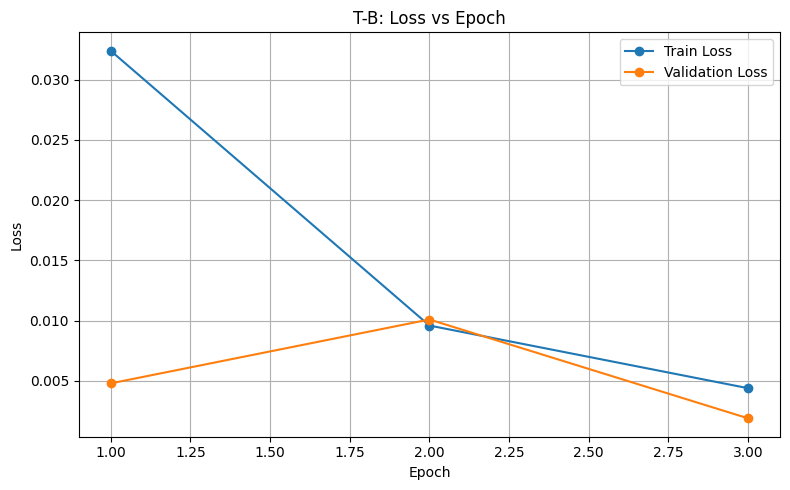

In [23]:
import matplotlib.pyplot as plt

epochs_TB = [1, 2, 3]

train_loss_TB = [
    0.0324,  # Epoch 1
    0.0096,  # Epoch 2
    0.0044   # Epoch 3
]

val_loss_TB = [
    0.0048,  # Epoch 1
    0.0101,  # Epoch 2
    0.0019  # Epoch 3
]

plt.figure(figsize=(8, 5))
plt.plot(epochs_TB, train_loss_TB, marker="o", label="Train Loss")
plt.plot(epochs_TB, val_loss_TB, marker="o", label="Validation Loss")

plt.title("T-B: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


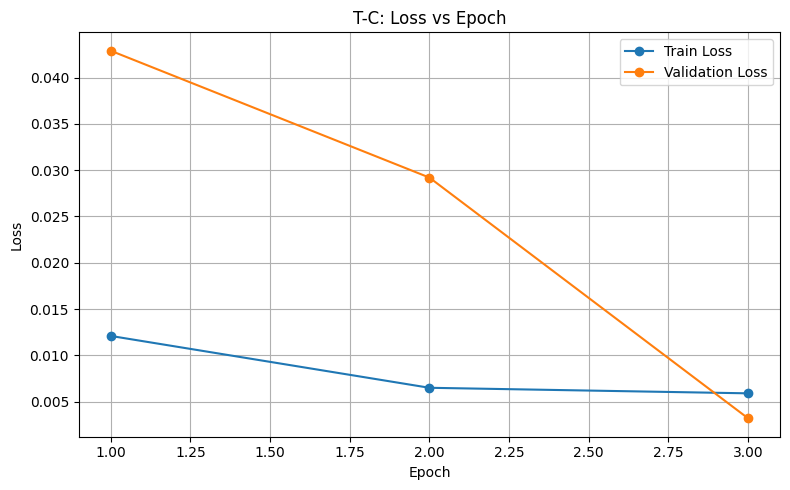

In [36]:
import matplotlib.pyplot as plt

epochs_TC = [1, 2, 3]

train_loss_TC = [
    0.0121,  # Epoch 1
    0.0065,  # Epoch 2
    0.0059   # Epoch 3
]

val_loss_TC = [
    0.0429,  # Epoch 1
    0.0292,  # Epoch 2
    0.0032   # Epoch 3
]

plt.figure(figsize=(8, 5))
plt.plot(epochs_TC, train_loss_TC, marker="o", label="Train Loss")
plt.plot(epochs_TC, val_loss_TC, marker="o", label="Validation Loss")

plt.title("T-C: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Confusion Matrix for T Models on Validation Set

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
import torch

def compute_confusion_matrix(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    cm = confusion_matrix(all_labels, all_preds)
    return cm


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

In [16]:
from torchvision import models
import torch.nn as nn

num_classes = 29

def build_resnet18_asl():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model


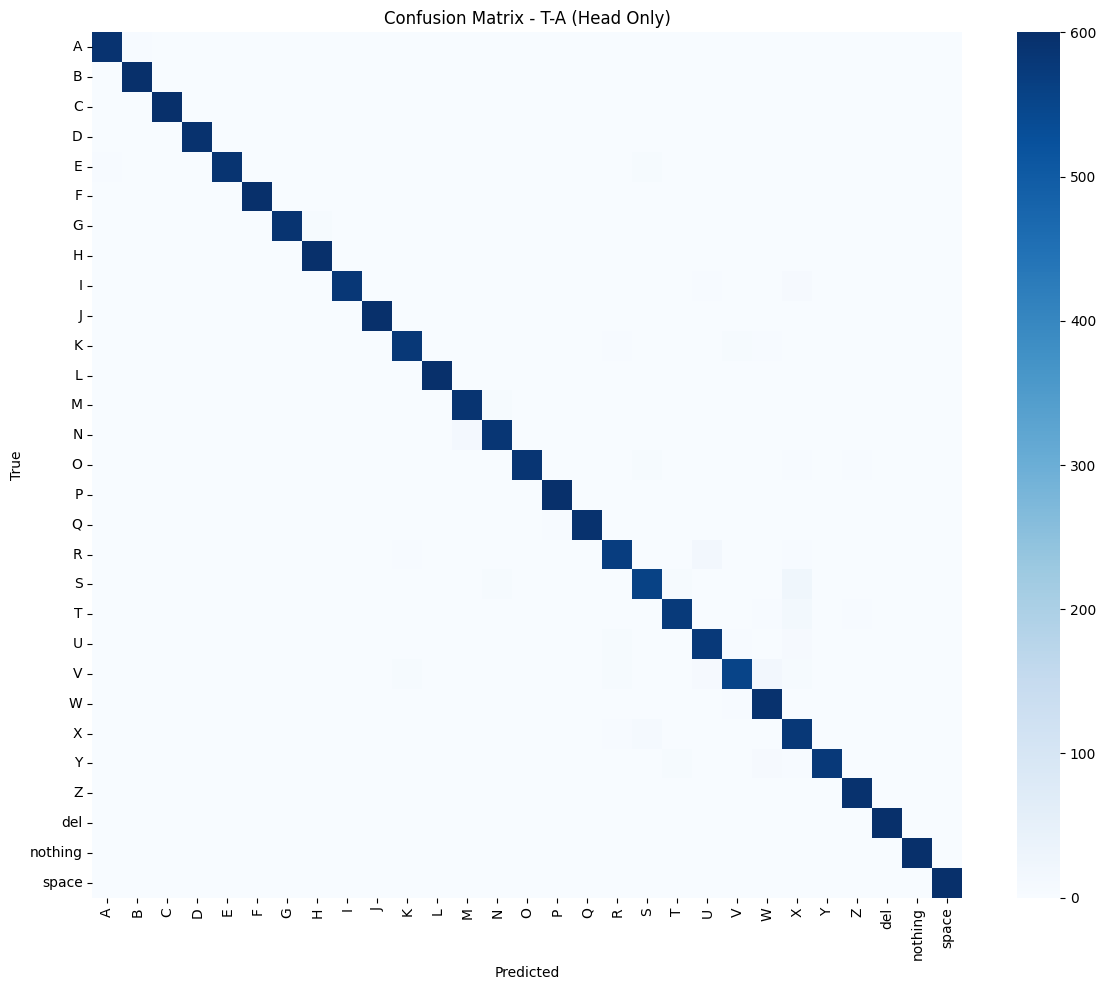

In [29]:
# Load T-A
model_TA = build_resnet18_asl()
state_TA = torch.load(
    "/content/drive/Shareddrives/429_Project/resnet18_TA_best.pth",
    map_location=device
)
model_TA.load_state_dict(state_TA)
model_TA.to(device)

cm_TA = compute_confusion_matrix(model_TA, val_loader, device)
plot_confusion_matrix(cm_TA, class_names, "Confusion Matrix - T-A (Head Only)")


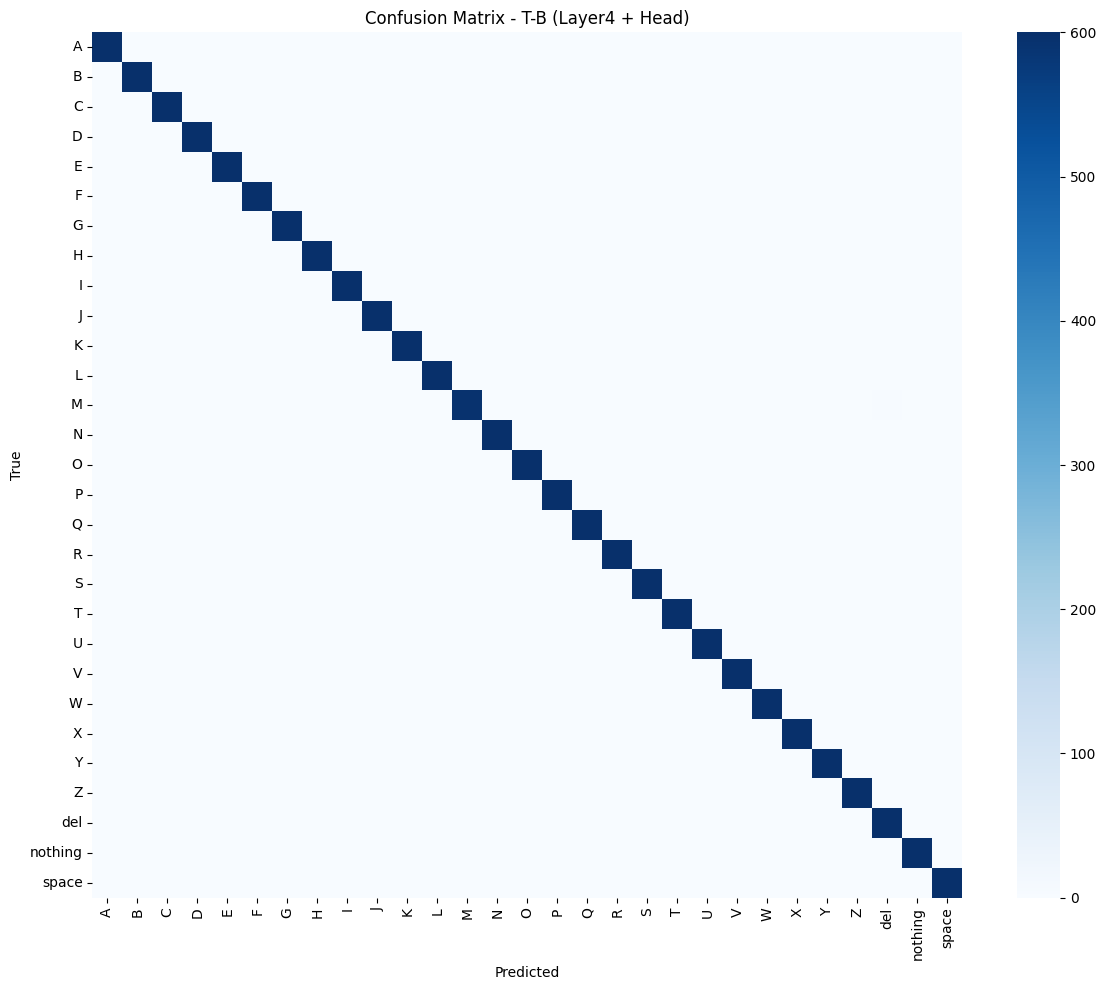

In [30]:
# Load T-B
model_TB = build_resnet18_asl()
state_TB = torch.load(
    "/content/drive/Shareddrives/429_Project/resnet18_TB_best.pth",
    map_location=device
)
model_TB.load_state_dict(state_TB)
model_TB.to(device)

cm_TB = compute_confusion_matrix(model_TB, val_loader, device)
plot_confusion_matrix(cm_TB, class_names, "Confusion Matrix - T-B (Layer4 + Head)")


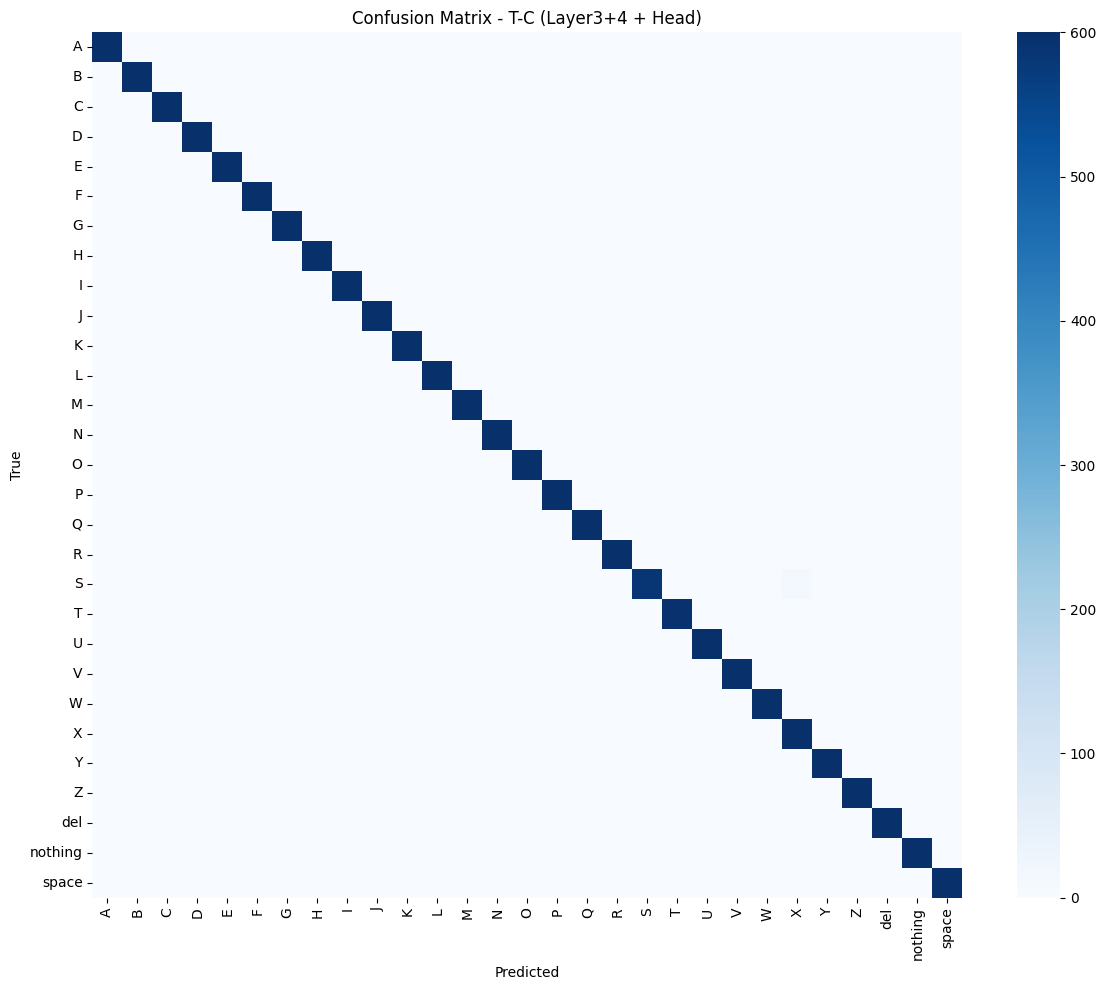

In [37]:
# Load T-C
model_TC = build_resnet18_asl()
state_TC = torch.load(
    "/content/drive/Shareddrives/429_Project/resnet18_TC_best.pth",
    map_location=device
)
model_TC.load_state_dict(state_TC)
model_TC.to(device)

cm_TC = compute_confusion_matrix(model_TC, val_loader, device)
plot_confusion_matrix(cm_TC, class_names, "Confusion Matrix - T-C (Layer3+4 + Head)")


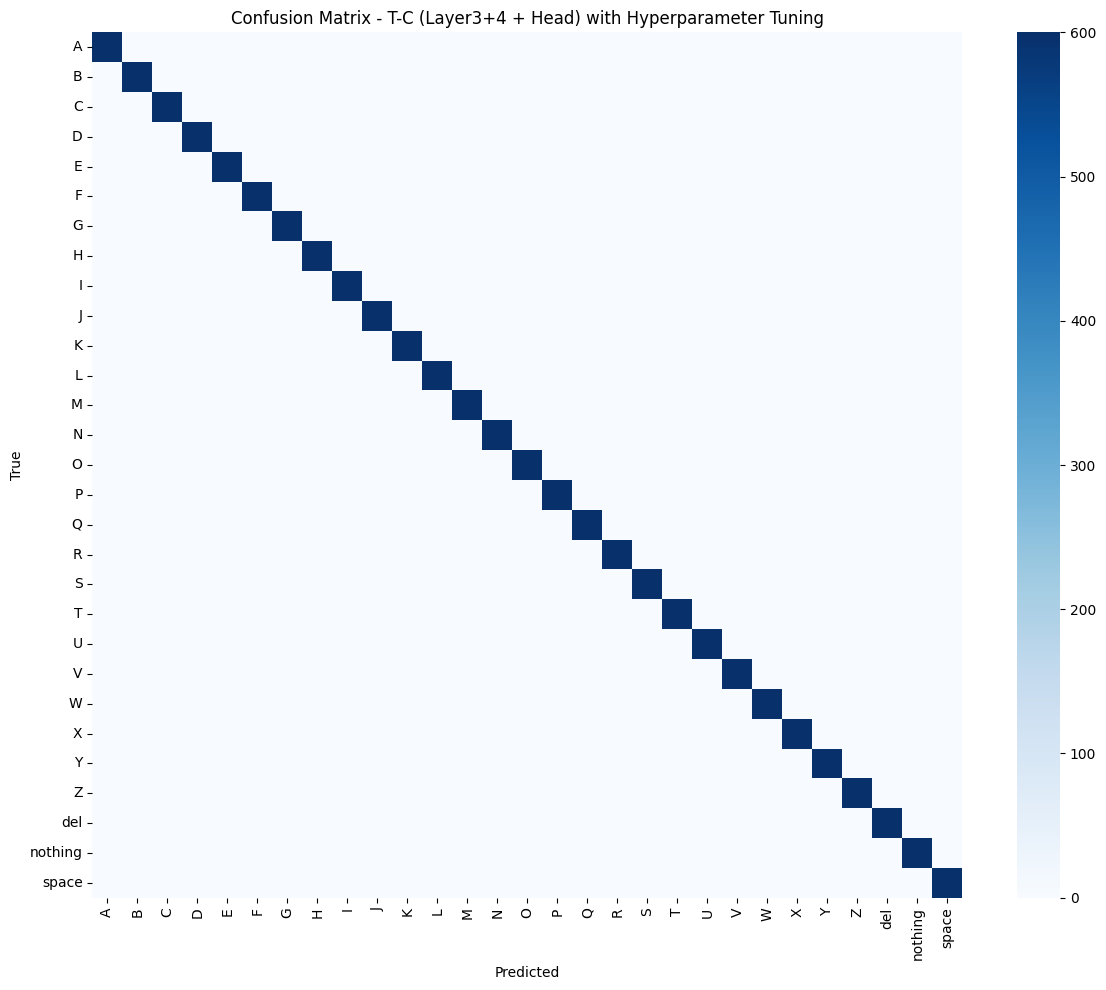

In [38]:
# Load T-C
model_TC = build_resnet18_asl()
state_TC = torch.load(
    "/content/drive/Shareddrives/429_Project/resnet18_TC_tuned_best.pth",
    map_location=device
)
model_TC.load_state_dict(state_TC)
model_TC.to(device)

cm_TC = compute_confusion_matrix(model_TC, val_loader, device)
plot_confusion_matrix(cm_TC, class_names, "Confusion Matrix - T-C (Layer3+4 + Head) with Hyperparameter Tuning")


## Confusion Matrix for T Models on Original Testset

In [17]:
import numpy as np
from torch.utils.data import DataLoader

# Make sure these exist from your TF block:
# test_image_paths  -> list of file paths
# test_labels       -> list of int labels (0..28)

test_paths = np.array(test_image_paths)
test_labels_np = np.array(test_labels)

test_dataset = ASLDataset(
    test_paths,
    test_labels_np,
    transform=val_transform   # same resize+normalize as validation
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,    # same batch size as train/val
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Test samples:", len(test_dataset))
print("Test batches:", len(test_loader))


Test samples: 28
Test batches: 1


In [18]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def compute_confusion_matrix(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    cm = confusion_matrix(all_labels, all_preds)
    return cm

def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=False,          # change to True if you want counts
        cmap="Blues",         # <- requested color
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [41]:
from torchvision import models
import torch.nn as nn

num_classes = 29

def build_resnet18_asl():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model


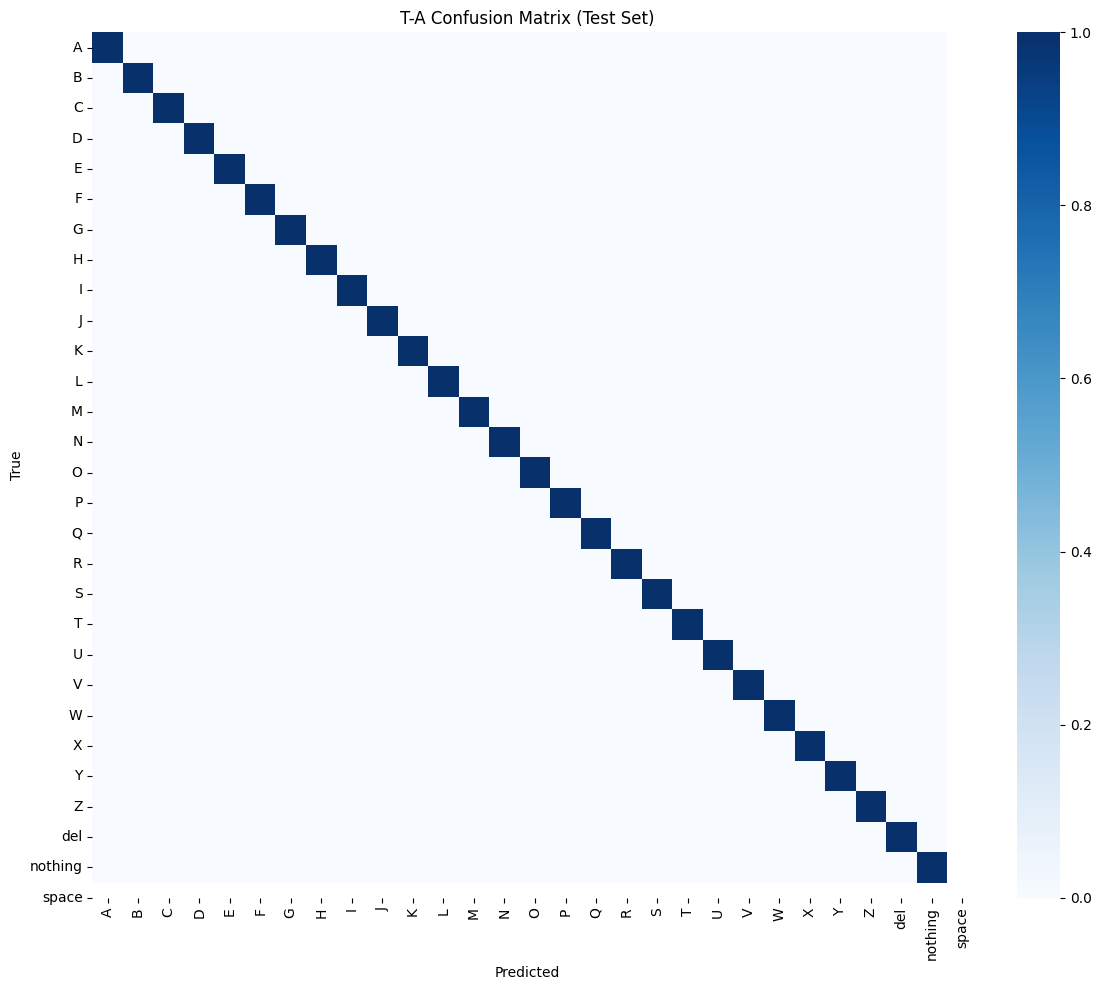

In [42]:
# T-A
model_TA = build_resnet18_asl()
state_TA = torch.load(
    "/content/drive/Shareddrives/429_Project/resnet18_TA_best.pth",  # adjust if needed
    map_location=device
)
model_TA.load_state_dict(state_TA)
model_TA.to(device)

cm_TA_test = compute_confusion_matrix(model_TA, test_loader, device)
plot_confusion_matrix(cm_TA_test, class_names, "T-A Confusion Matrix (Test Set)")


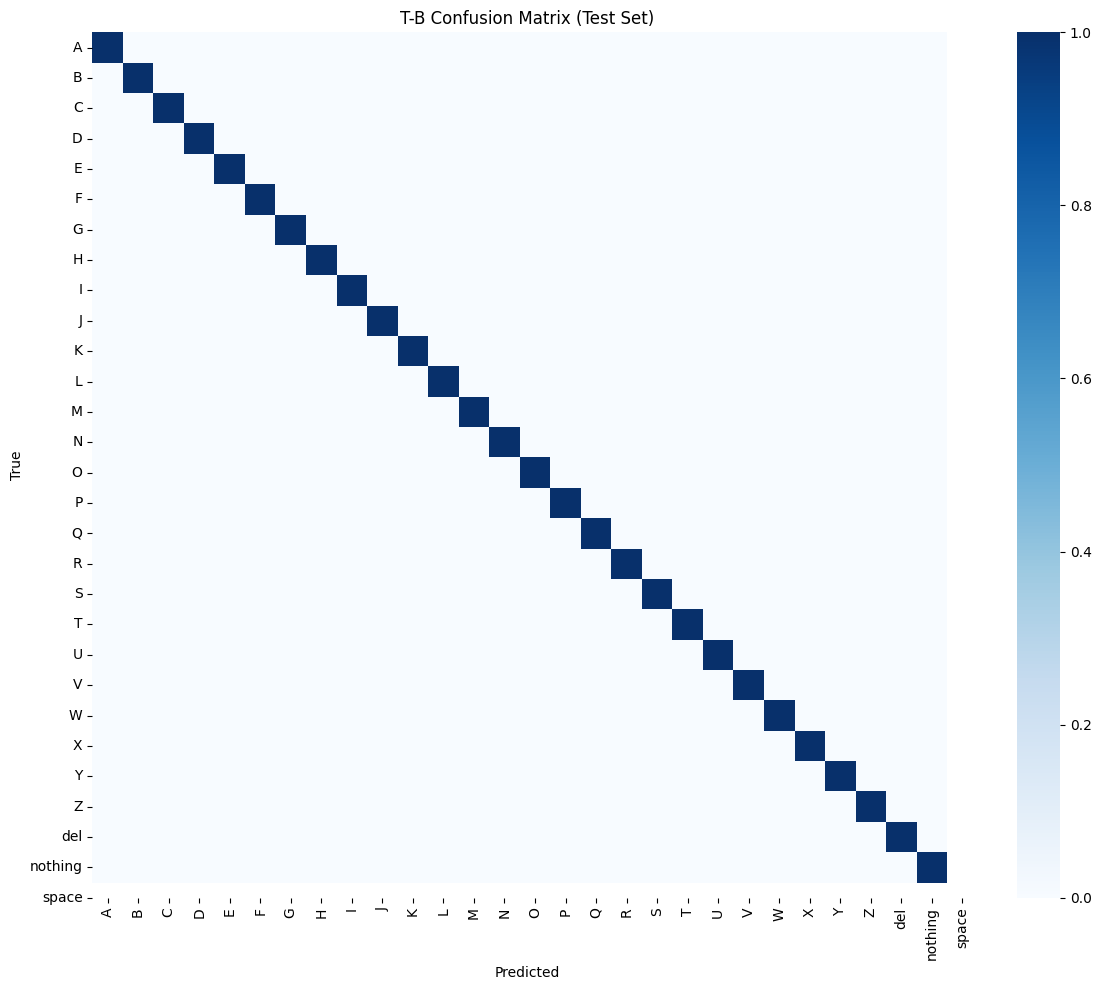

In [43]:
# T-B
model_TB = build_resnet18_asl()
state_TB = torch.load(
    "/content/drive/Shareddrives/429_Project/resnet18_TB_best.pth",
    map_location=device
)
model_TB.load_state_dict(state_TB)
model_TB.to(device)

cm_TB_test = compute_confusion_matrix(model_TB, test_loader, device)
plot_confusion_matrix(cm_TB_test, class_names, "T-B Confusion Matrix (Test Set)")


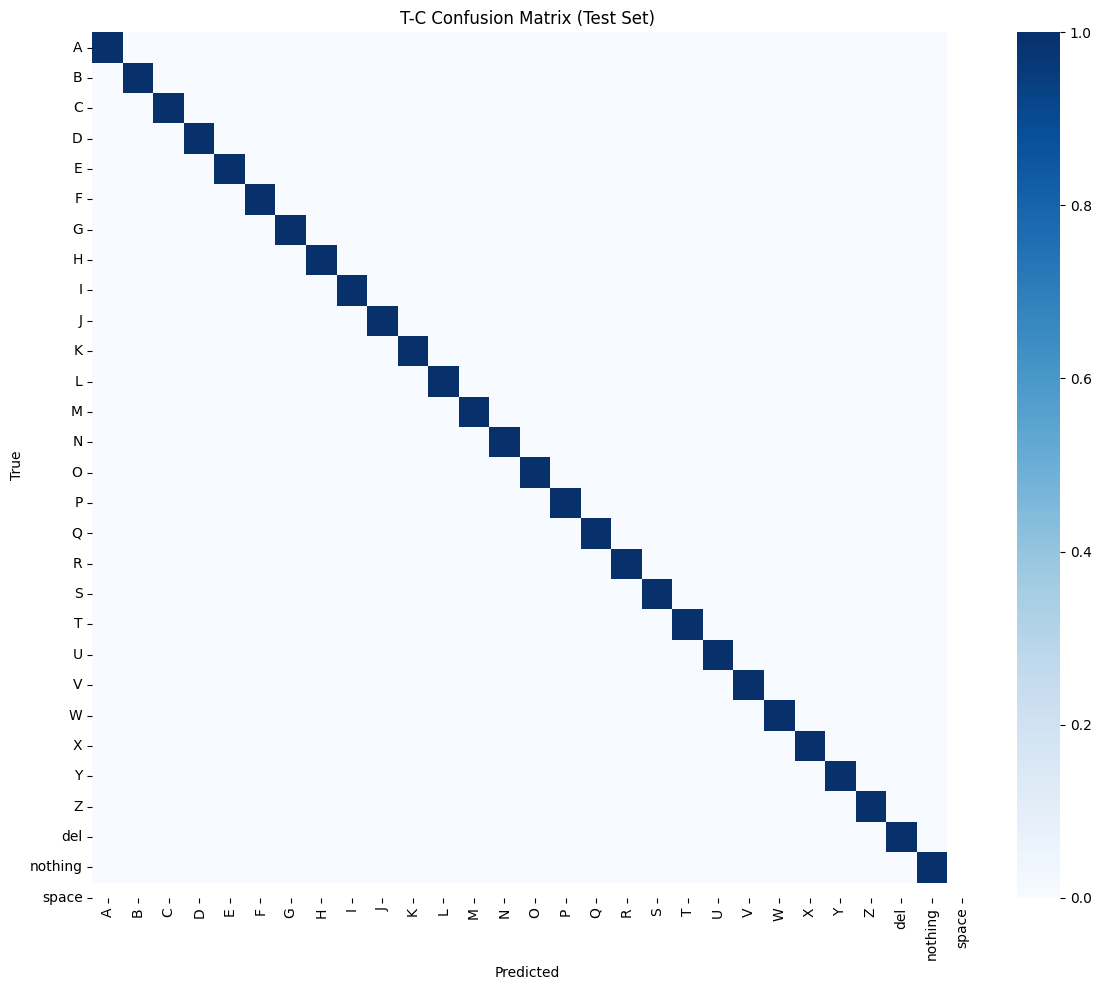

In [44]:
# T-C
model_TC = build_resnet18_asl()
state_TC = torch.load(
    "/content/drive/Shareddrives/429_Project/resnet18_TC_best.pth",
    map_location=device
)
model_TC.load_state_dict(state_TC)
model_TC.to(device)

cm_TC_test = compute_confusion_matrix(model_TC, test_loader, device)
plot_confusion_matrix(cm_TC_test, class_names, "T-C Confusion Matrix (Test Set)")
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

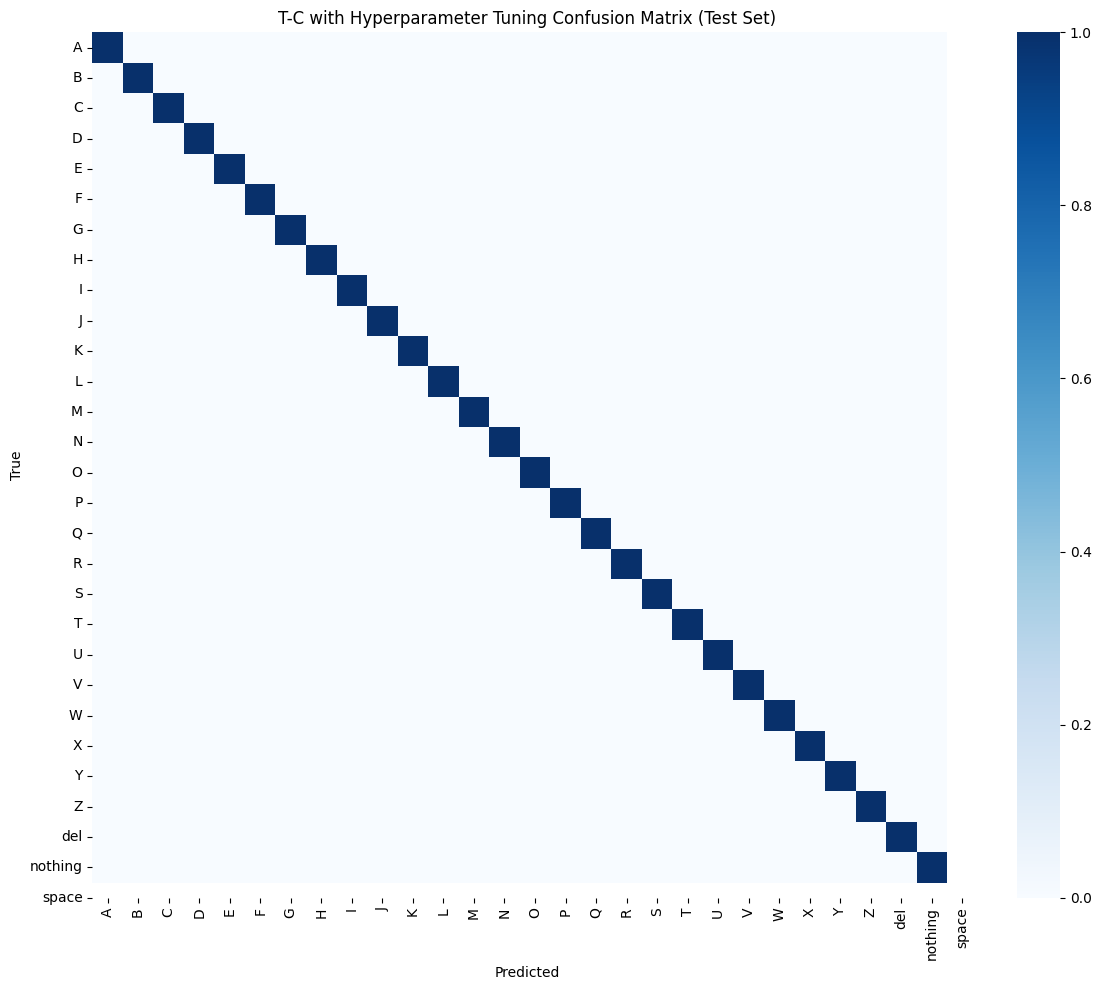

In [46]:
# T-C
model_TC = build_resnet18_asl()
state_TC = torch.load(
    "/content/drive/Shareddrives/429_Project/resnet18_TC_tuned_best.pth",
    map_location=device
)
model_TC.load_state_dict(state_TC)
model_TC.to(device)

cm_TC_test = compute_confusion_matrix(model_TC, test_loader, device)
plot_confusion_matrix(cm_TC_test, class_names, "T-C with Hyperparameter Tuning Confusion Matrix (Test Set)")


## Confusion Matrix for All Models on New Testset

In [19]:
import os
newtest = "/content/drive/Shareddrives/429_Project/MYHANDS"

In [20]:
import os
import tensorflow as tf
import numpy as np

# Define constants that were missing
IMG_HEIGHT = 200
IMG_WIDTH = 200
BATCH_SIZE = 32

# Function to decode and preprocess images - Copied from previous cell (8fb0e95e)
def decode_img(img_path, img_height, img_width):
    img = tf.io.read_file(img_path)
    # Use tf.image.decode_jpeg for .jpg files for more robustness
    img = tf.image.decode_jpeg(img, channels=3) # Decode to 3 channels (RGB)
    img = tf.image.convert_image_dtype(img, tf.float32) # Normalize to [0,1]
    img = tf.image.resize(img, [img_height, img_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

def process_path(file_path, label):
    img = decode_img(file_path, IMG_HEIGHT, IMG_WIDTH)
    return img, label

# Re-initialize lists for new test data
new_test_image_paths = []
new_test_labels = []

for filename in os.listdir(newtest):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        image_path = os.path.join(newtest, filename)
        new_test_image_paths.append(image_path)

        # Extract label from filename (e.g., 'A1.jpg' -> 'A', 'B_test.jpg' -> 'B')
        label_raw = ''
        for char in filename:
            if char.isalpha():
                label_raw += char
            else:
                break
        label_name = label_raw.upper()

        if label_name in class_name_to_label_id:
            new_test_labels.append(class_name_to_label_id[label_name])
        else:
            print(f"Warning: Label '{label_name}' from '{filename}' not found in training class names. Skipping.")

print(f"Found {len(new_test_image_paths)} images for new testing.")

# Convert to TensorFlow tensors
new_test_image_paths_tensor = tf.constant(new_test_image_paths)
new_test_labels_tensor = tf.constant(new_test_labels, dtype=tf.int32)

# Create the new test dataset from tensors and apply preprocessing
new_test_ds = tf.data.Dataset.from_tensor_slices((new_test_image_paths_tensor, new_test_labels_tensor))
new_test_ds = new_test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
new_test_ds = new_test_ds.batch(BATCH_SIZE)
new_test_ds = new_test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Number of batches in new test dataset: {tf.data.experimental.cardinality(new_test_ds).numpy()}")

Found 20 images for new testing.
Number of batches in new test dataset: 1


In [21]:
# Invert the mapping so you can see label name from id
id_to_class_name = {v: k for k, v in class_name_to_label_id.items()}

for path, label_id in list(zip(new_test_image_paths, new_test_labels))[:10]:
    filename = os.path.basename(path)
    print(filename, " -> label_id:", label_id, " -> label_name:", id_to_class_name[label_id])

L1.jpg  -> label_id: 11  -> label_name: L
W1.jpg  -> label_id: 22  -> label_name: W
V1.jpg  -> label_id: 21  -> label_name: V
X1.jpg  -> label_id: 23  -> label_name: X
Y1.jpg  -> label_id: 24  -> label_name: Y
V2.jpg  -> label_id: 21  -> label_name: V
W2.jpg  -> label_id: 22  -> label_name: W
T1.jpg  -> label_id: 19  -> label_name: T
S1.jpg  -> label_id: 18  -> label_name: S
D1.jpg  -> label_id: 3  -> label_name: D


In [26]:
new_test_paths = np.array(new_test_image_paths)
new_test_labels_np = np.array(new_test_labels)

new_test_dataset = ASLDataset(
    new_test_paths,
    new_test_labels_np,
    transform=val_transform  # same transforms as validation & old test
)

new_test_loader = DataLoader(
    new_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("New test samples:", len(new_test_dataset))
print("New test batches:", len(new_test_loader))


New test samples: 20
New test batches: 1


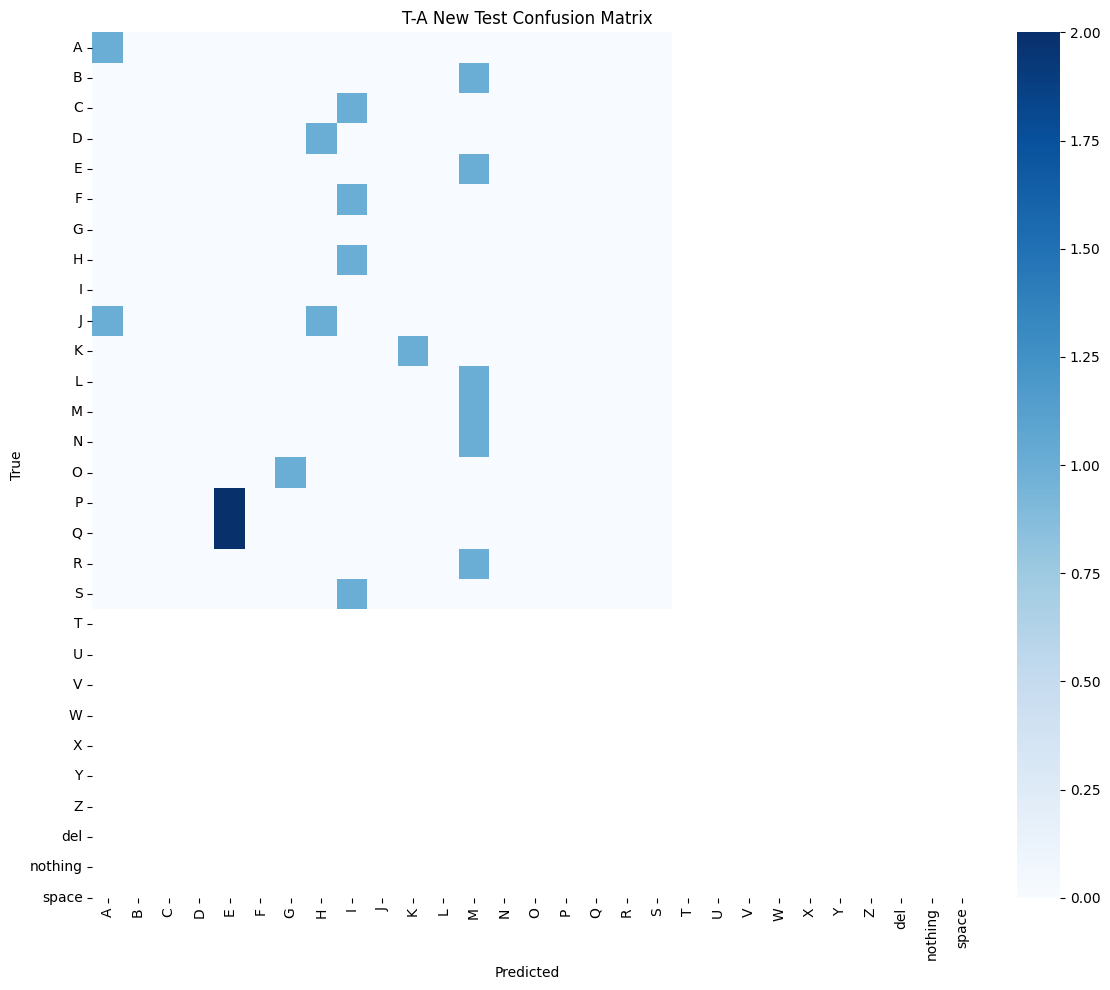

In [52]:
model_TA = build_resnet18_asl()
state_TA = torch.load("/content/drive/Shareddrives/429_Project/resnet18_TA_best.pth",
                      map_location=device)
model_TA.load_state_dict(state_TA)
model_TA.to(device)

cm_TA_new = compute_confusion_matrix(model_TA, new_test_loader, device)
plot_confusion_matrix(cm_TA_new, class_names, "T-A New Test Confusion Matrix")


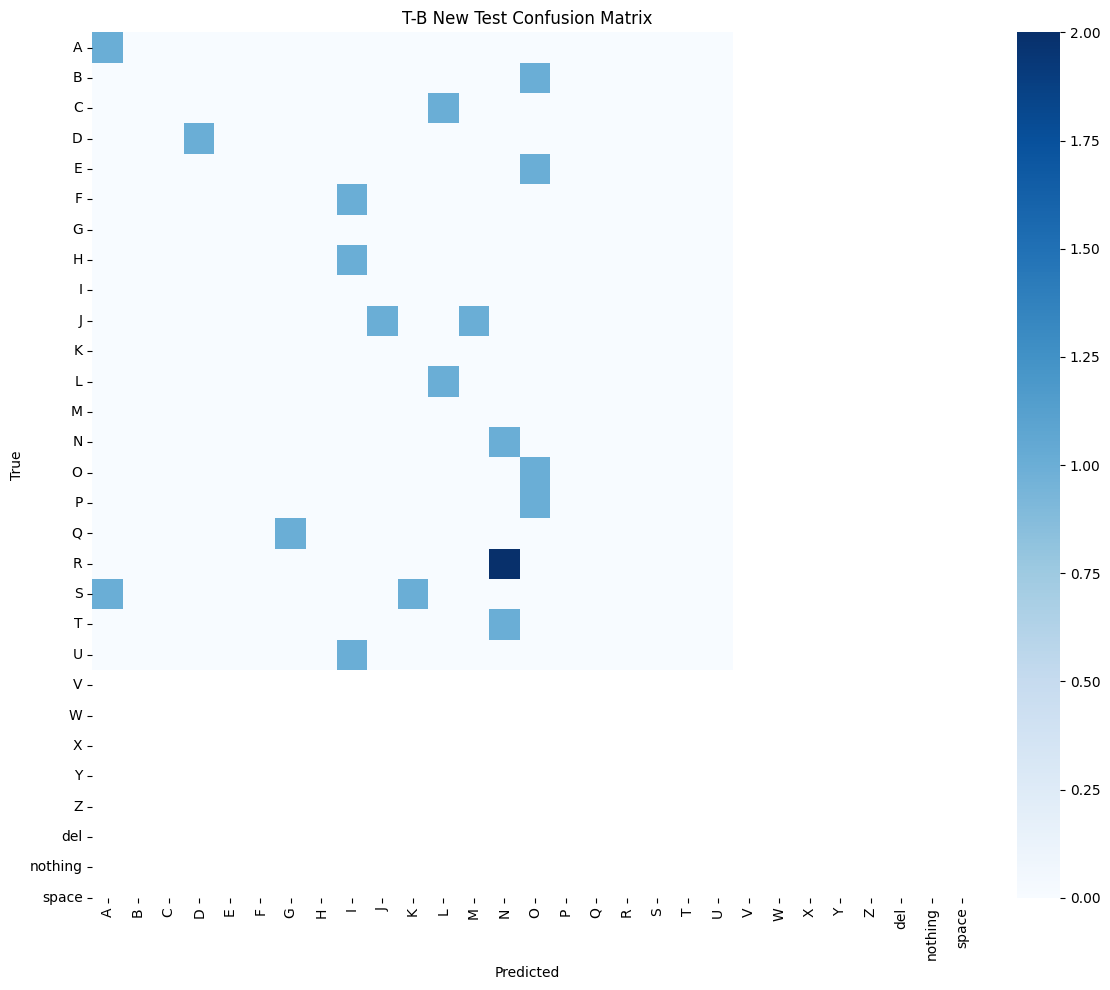

In [53]:
model_TB = build_resnet18_asl()
state_TB = torch.load("/content/drive/Shareddrives/429_Project/resnet18_TB_best.pth",
                      map_location=device)
model_TB.load_state_dict(state_TB)
model_TB.to(device)

cm_TB_new = compute_confusion_matrix(model_TB, new_test_loader, device)
plot_confusion_matrix(cm_TB_new, class_names, "T-B New Test Confusion Matrix")


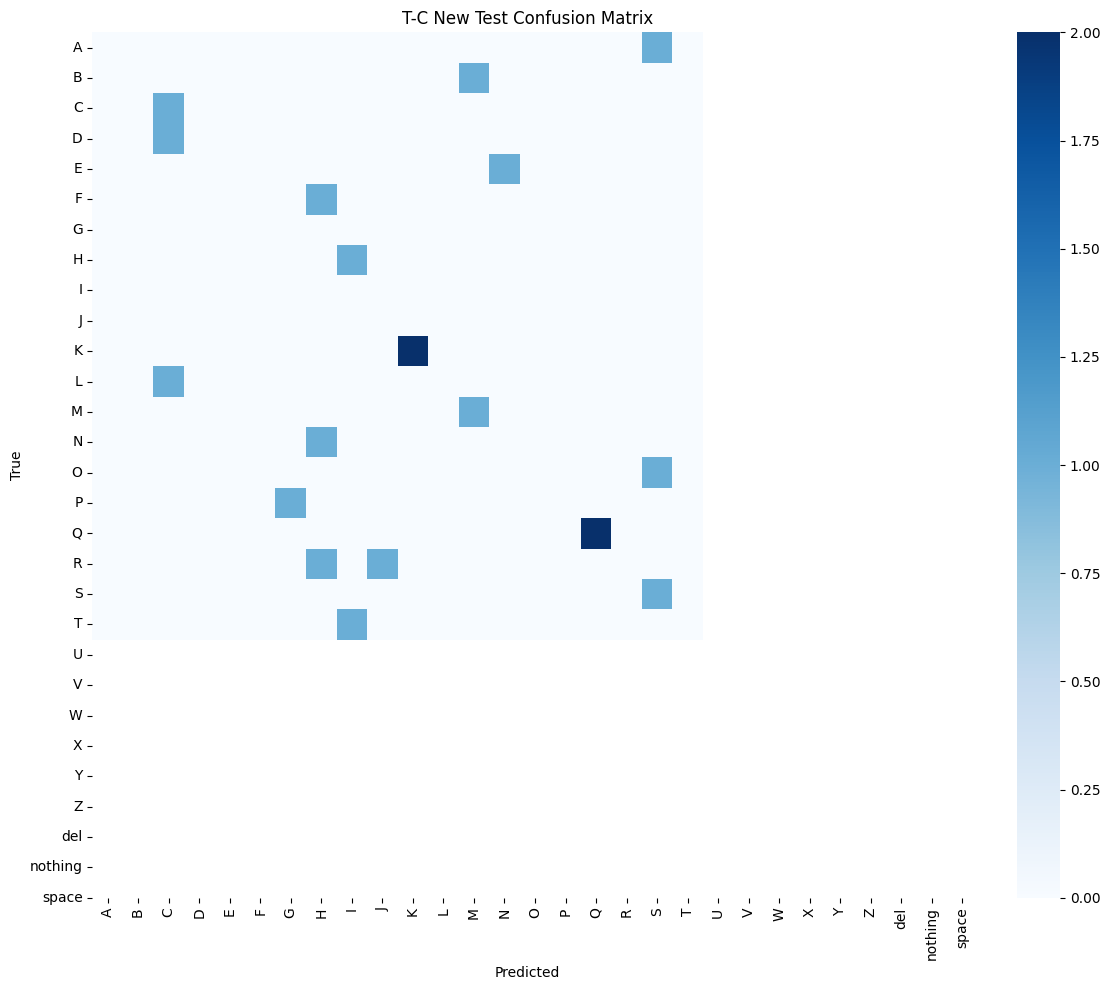

In [54]:
model_TC = build_resnet18_asl()
state_TC = torch.load("/content/drive/Shareddrives/429_Project/resnet18_TC_best.pth",
                      map_location=device)
model_TC.load_state_dict(state_TC)
model_TC.to(device)

cm_TC_new = compute_confusion_matrix(model_TC, new_test_loader, device)
plot_confusion_matrix(cm_TC_new, class_names, "T-C New Test Confusion Matrix")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 55.0MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


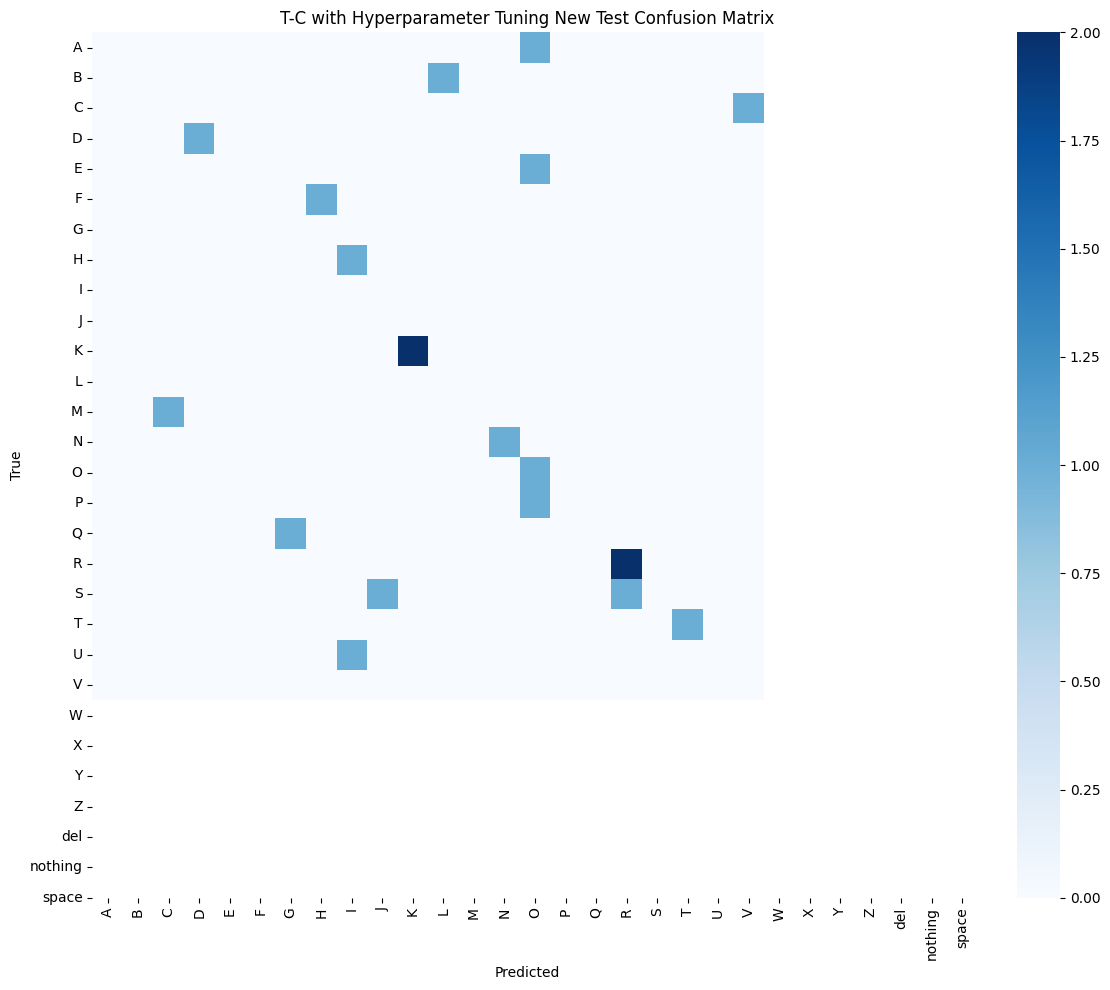

In [23]:
model_TC = build_resnet18_asl()
state_TC = torch.load("/content/drive/Shareddrives/429_Project/resnet18_TC_tuned_best.pth",
                      map_location=device)
model_TC.load_state_dict(state_TC)
model_TC.to(device)

cm_TC_new = compute_confusion_matrix(model_TC, new_test_loader, device)
plot_confusion_matrix(cm_TC_new, class_names, "T-C with Hyperparameter Tuning New Test Confusion Matrix")
